# EXERCICE 7 : REGRESSION LINEAIRE MULTIPLE AVEC REGULARISATION + VALIDATION CROISEE


Inspire de http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html


In [33]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


#### Génération de donnée synthétiques...

In [34]:

np.random.seed(31)

#... definition de n et p
n = 75
p =  200   #remarque : n<200 => necessite de selectionner des variables

#... simulation de X
X = np.random.randn(n, p) #remarque : on ne tient pas en compte les $beta_0$

#... generation du vecteur beta dans lequel seules 10 valeurs sont non-nulles
beta = 3 * np.random.randn(p)
inds = np.arange(p)
np.random.shuffle(inds)
beta[inds[10:]] = 0 

#... simulation de y 
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))


# REMARQUE IMPORTANTE : y ne dépend que des variables i pour lesquelles beta[i] est non-nul


# ... coupe en deux les donnees en donnees d'apprentissage et donnes test
thresh=n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]


#### Régression linéaire avec régularisation Lasso ...


In [35]:

from sklearn.linear_model import Lasso

alpha = 0.5
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)


####  Représentation du résultat


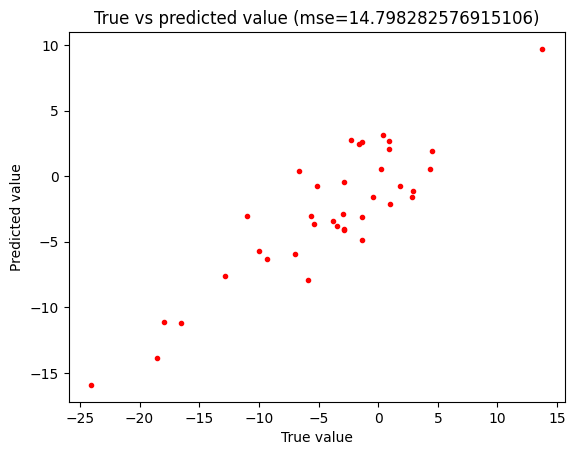

In [36]:
fig = plt.figure()
plt.plot(y_test, y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
plt.show()



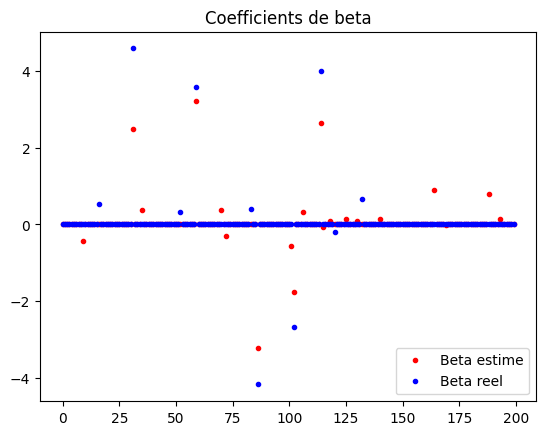

In [37]:

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()



### <span style="color:blue">QUESTION 1</span> :

Jouez l'exemple avec  n=1000, n=100, n=75, n=50, n=25. Qu'en deduisez vous sur l'impact du nombre d'observations

### <span style="color:blue">REPONSE 1</span> :

...


In [38]:
# quand n augmente, l'écart entre réel et prévision diminue et les betas se rapprochent de 0


### <span style="color:blue">QUESTION 2</span> :

On garde n=75. Utilisez la validation croisee de type K-folds (typiquement 8-Folds) pour trouver le meilleur coefficient *alpha* au sens de la MSE. Pour chaque *alpha* testé, on gardera comme score la MSE moyenne obtenue sur tous les *folds*.

Remarque : la recherche d'un bon coefficient *alpha* pourra d'abord se faire sur une échelle exponentielle assez large (ex: 0.001, 0.01, 0.1, ...) puis être raffinée sur une échelle plus fine.  

### <span style="color:blue">REPONSE 2</span> :

Best alpha: 0.20691380811147903


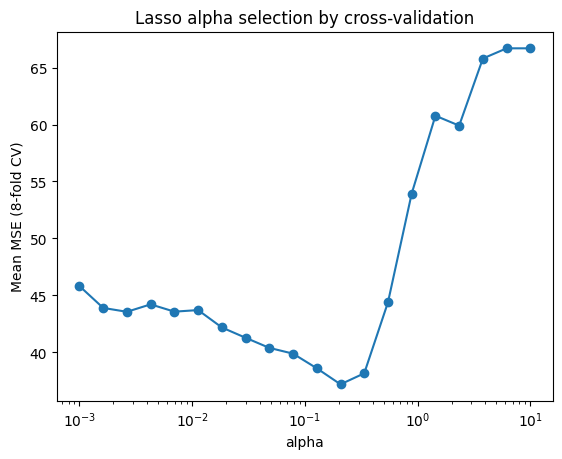

Test MSE with best alpha: 15.788947252923506


In [39]:


from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

alphas = np.logspace(-3, 1, 20)  # Test alphas from 0.001 to 10
kf = KFold(n_splits=8, shuffle=True, random_state=42)

mean_mse = []

for alpha in alphas:
    mse_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_tr, y_tr)
        y_pred = lasso.predict(X_val)
        mse_folds.append(mean_squared_error(y_val, y_pred))
    mean_mse.append(np.mean(mse_folds))

best_alpha = alphas[np.argmin(mean_mse)]
print("Best alpha:", best_alpha)

plt.figure()
plt.semilogx(alphas, mean_mse, marker='o')
plt.xlabel('alpha')
plt.ylabel('Mean MSE (8-fold CV)')
plt.title('Lasso alpha selection by cross-validation')
plt.show()

# Fit Lasso with best alpha on all training data
lasso_best = Lasso(alpha=best_alpha, max_iter=10000)
lasso_best.fit(X_train, y_train)
y_pred_best = lasso_best.predict(X_test)
mse_score_best = mean_squared_error(y_test, y_pred_best)
print("Test MSE with best alpha:", mse_score_best)

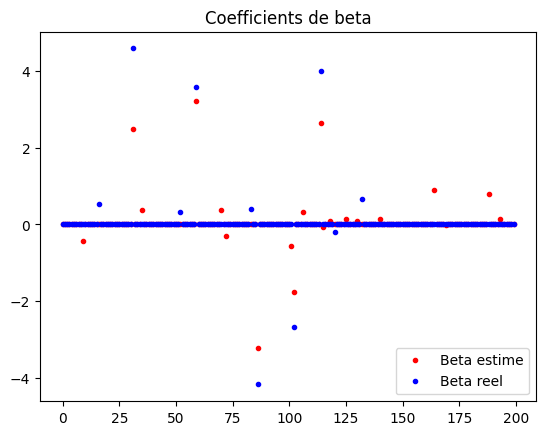

In [40]:
#représentation des coefficients estimés (lasso_regressor.coef_) et de ceux
#avec lesquels les données ont été simulées (beta)

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()


### <span style="color:blue">QUESTION 3</span> :

De manère alternative, codez et testez maintenant une sélection de type *forward* avec un critère de sélection *BIC*.

Comparez les résultats avec ceux obtenus à l'aide de la pénalisation LASSO.

### <span style="color:blue">REPONSE 3</span> :


Test MSE (Forward Selection + BIC): 20.05515186046388


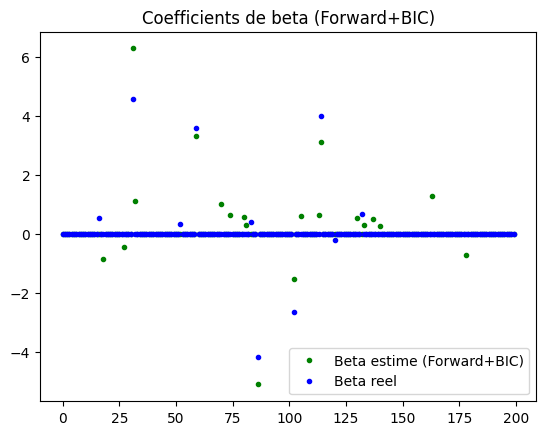

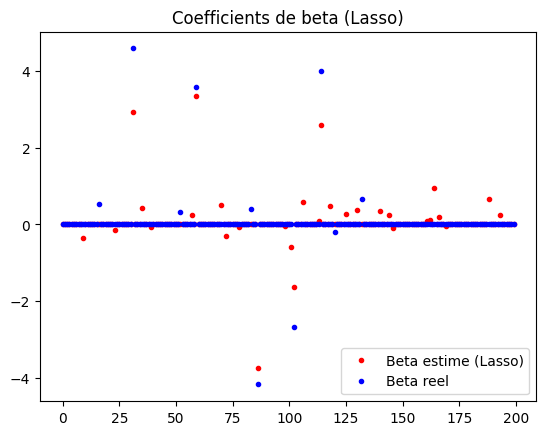

Test MSE (Lasso, best alpha): 15.788947252923506


In [41]:


# ...existing code...

from sklearn.linear_model import LinearRegression
from sklearn.base import clone

def compute_bic(y_true, y_pred, n_params):
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    bic = n * np.log(mse) + n_params * np.log(n)
    return bic

def forward_selection_bic(X, y, max_features=20):
    n, p = X.shape
    selected = []
    remaining = list(range(p))
    best_bic = np.inf
    best_model = None
    best_coefs = None

    for _ in range(max_features):
        bic_candidates = []
        models = []
        for idx in remaining:
            features = selected + [idx]
            model = LinearRegression()
            model.fit(X[:, features], y)
            y_pred = model.predict(X[:, features])
            bic = compute_bic(y, y_pred, len(features))
            bic_candidates.append(bic)
            models.append((model, features))
        min_bic = np.min(bic_candidates)
        if min_bic < best_bic:
            best_bic = min_bic
            best_idx = np.argmin(bic_candidates)
            selected.append(remaining[best_idx])
            best_model, best_features = models[best_idx]
            best_coefs = np.zeros(p)
            best_coefs[selected] = best_model.coef_
            remaining.pop(best_idx)
        else:
            break
    return selected, best_coefs, best_model

# Run forward selection on training data
selected_features, fs_coefs, fs_model = forward_selection_bic(X_train, y_train, max_features=20)

# Predict on test data using selected features
y_pred_fs = fs_model.predict(X_test[:, selected_features])
mse_fs = mean_squared_error(y_test, y_pred_fs)
print("Test MSE (Forward Selection + BIC):", mse_fs)

# Plot coefficients: forward selection vs true beta
plt.figure()
plt.plot(fs_coefs, 'g.', label='Beta estime (Forward+BIC)')
plt.plot(beta, 'b.', label='Beta reel')
plt.legend(loc='lower right')
plt.title('Coefficients de beta (Forward+BIC)')
plt.show()

# Compare with Lasso (best alpha from previous question)
plt.figure()
plt.plot(lasso_best.coef_, 'r.', label='Beta estime (Lasso)')
plt.plot(beta, 'b.', label='Beta reel')
plt.legend(loc='lower right')
plt.title('Coefficients de beta (Lasso)')
plt.show()

print("Test MSE (Lasso, best alpha):", mse_score_best)
